In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Monte Carlo Methods

Broadly, any simulation that relies on random sampling to obtain results falls into the category of Monte Carlo methods. Another common type of statistical experiment is the use of repeated sampling from a data set, including the bootstrap, jackknife and permutation resampling. Often, they are combined, as when we use a random set of permutations rather than the full set of permutations, which grows as $O(n!))$ and is typically infeasible. What Monte Carlo simulations have in common is that they are typically more flexible but also more computationally demanding than methods based on asymptotic results. Because of their flexibility and the inexorable growth of computing power, I expect these computational simulation methods to only become more popular over time.

### Setting the random seed

In any probabilistic simulation, it is prudent to set the random number seed so that results can be replicated

In [2]:
np.random.seed(123)

## Bootstrap

The bootstrap is commonly used to estimate statistics when a closed form solution may not exist. 

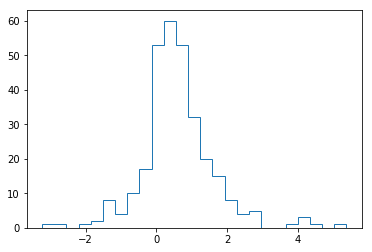

In [3]:
# For example, what is the 95% confidence interval for 
# the 10th percentile of this data set if you didn't know how it was generated?

x = np.concatenate([np.random.exponential(size=200), np.random.normal(size=100)])
plt.hist(x, 25, histtype='step', linewidth=1)
pass


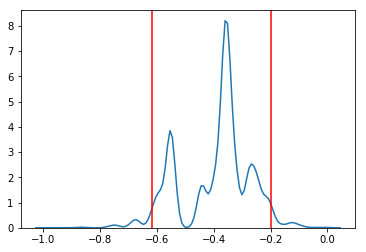

In [4]:
n = len(x)
reps = 10000
xb = np.random.choice(x, (n, reps))
mb = np.percentile(xb, 10, axis=0)
mb.sort()

lower, upper = np.percentile(mb, [2.5, 97.5])
sns.kdeplot(mb)
for v in (lower, upper):
    plt.axvline(v, color='red')

## Permutation resampling

#### For flexible hypothesis testing

Suppose you have two data sets from unknown distributions and you want to test if some arbitrary statistic (e.g the 7th percentile) is the same in the two data sets - what can you do?

An appropriate test statistic is the difference between the 7th percentile, and if we knew the null distribution of this statistic, we could test for the null hypothesis that the statistic = 0. Permuting the labels of the 2 data sets allows us to create the empirical null distribution.

#### Create two data sets for comparison

In [5]:
x = np.r_[np.random.exponential(size=200), 
          np.random.normal(0, 1, size=100)]
y = np.r_[np.random.exponential(size=250), 
          np.random.normal(0, 1, size=50)]

#### Generate permutations of labels for 10,000 comparisons

In [6]:
n1, n2 = map(len, (x, y))
reps = 10000

data = np.r_[x, y]
ps = np.array([np.random.permutation(n1+n2) for i in range(reps)])

#### Estimate empirical null distribution for differences between samples

In [7]:
xp = data[ps[:, :n1]]
yp = data[ps[:, n1:]]
samples = np.percentile(xp, 7, axis=1) - np.percentile(yp, 7, axis=1)

#### Plot the results

p-value = 0.0066


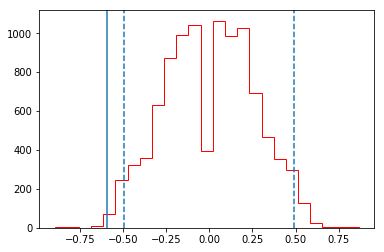

In [8]:
plt.hist(samples, 25, histtype='step', color='red')
test_stat = np.percentile(x, 7) - np.percentile(y, 7)
plt.axvline(test_stat)
plt.axvline(np.percentile(samples, 2.5), linestyle='--')
plt.axvline(np.percentile(samples, 97.5), linestyle='--')
print("p-value =", 2*np.sum(samples >= np.abs(test_stat))/reps)

### Adjusting p-values for multiple testing

We will make up some data - a typical example is trying to identify genes that are differentially expressed in two groups of people, perhaps those who are healthy and those who are sick. For each gene, we can perform a t-test to see if the gene is differentially expressed across the two groups at some nominal significance level, typically 0.05. When we have many genes, this is unsatisfactory since 5% of the genes will be found to be differentially expressed just by chance.

One possible solution is to use the family-wise error rate (FWER) instead - most simply using the Bonferroni adjusted p-value. An alternative is to use the non-parametric method originally proposed by Young and Westfall that uses permutation resampling to estimate the adjusted p-value without the assumptions of independence that the Bonferroni method makes.

####  Making up data for 100 genes across 1000 subjects and  "spike" with 5 genes that are differentially expressed

In [9]:
x = np.array([1,2,3]).reshape((-1,1))

In [10]:
x @ x.T

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [11]:
ngenes = 100
ncases = 500
nctrls = 500
nsamples = ncases + nctrls
x = np.random.normal(0, 1, (ngenes, nsamples))

target_genes = [5,15,25,35,45]
x[target_genes, ncases:] += np.random.normal(1, 1, (len(target_genes), ncases))

In [12]:
import scipy.stats as stats

#### Unadjusted p-values

In [13]:
%precision 3

'%.3f'

In [14]:
t, p0 = stats.ttest_ind(x[:, :ncases], x[:, ncases:], axis=1)
idx = p0 < 0.05
list(zip(np.nonzero(idx)[0], p0[idx]))

[(5, 8.861633793213916e-34),
 (13, 0.004021295263810689),
 (15, 8.18154675044954e-31),
 (25, 3.014924313176618e-36),
 (35, 1.1077458174150005e-32),
 (45, 2.201067465810549e-36),
 (50, 0.0010625565688156683),
 (55, 0.04584538192922787),
 (56, 0.03963857815316052),
 (66, 0.0026269112905303736),
 (89, 0.007354071452371958),
 (94, 0.020919360342058886)]

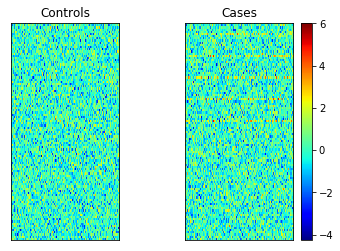

In [15]:
vmin = x.min()
vmax = x.max()

plt.subplot(121)
plt.imshow(x[:, :ncases], extent=[0, 1, 0, 2], interpolation='nearest', 
           vmin=vmin, vmax=vmax, cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title('Controls')
plt.subplot(122)
plt.imshow(x[:, ncases:], extent=[0, 1, 0, 2], interpolation='nearest', 
           vmin=vmin, vmax=vmax, cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title('Cases')
plt.colorbar()
pass

#### Bonferroni correction

In [16]:
p1 = np.clip(len(p0) * p0, 0, 1)
idx = p1 < 0.05
list(zip(np.nonzero(idx)[0], p1[idx]))

[(5, 8.861633793213915e-32),
 (15, 8.18154675044954e-29),
 (25, 3.014924313176618e-34),
 (35, 1.1077458174150005e-30),
 (45, 2.201067465810549e-34)]

#### Westfall and Young (Permutation-resampling based family-wise error rate)

Is similar to Bonferroni when features are uncorrelated, but is more powerful when features are correlated.

In [17]:
nperms = 10000
k = ngenes

t, p0 = stats.ttest_ind(x[:, :ncases], x[:, ncases:], axis=1)
ranks = np.argsort(np.abs(t))[::-1]
counts = np.zeros((nperms, k))
for i in range(nperms):
    u = np.zeros(k)
    sidx = np.random.permutation(nsamples)
    y = x[:, sidx]
    tb, pb = stats.ttest_ind(y[:, :ncases], y[:, ncases:], axis=1)
    u[k-1] = np.abs(tb[ranks[k-1]])
    for j in range(k-2, -1, -1):
        u[j] = max(u[j+1], np.abs(tb[ranks[j]]))
    counts[i] = (u >= np.abs(t[ranks]))

p2 = np.sum(counts, axis=0)/nperms
for i in range(1, k):
    p2[i] = max(p2[i],p2[i-1])
idx = p2 < 0.05
list(zip(ranks, p2[idx]))

[(45, 0.0), (25, 0.0), (5, 0.0), (35, 0.0), (15, 0.0)]

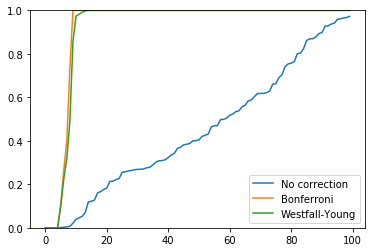

In [18]:
plt.plot(sorted(p0), label='No correction')
plt.plot(sorted(p1), label='Bonferroni')
plt.plot(sorted(p2), label='Westfall-Young')
plt.ylim([0,1])
plt.legend(loc='best')
pass

#### What if genes are correlated?

The Bonferrroni assumes that tests are independent. However, often test results are strongly correlated (e.g. genes in the same pathway behave similarly) and the Bonferroni will be too conservative. However the permutation-resampling method still works in the presence of correlations.

In [19]:
ngenes = 100
ncases = 500
nctrls = 500
nsamples = ncases + nctrls

# use random number seed knwon to give a differnece
np.random.seed(52)
x = np.repeat(np.random.normal(0, 1, (1, nsamples)), ngenes, axis=0)

In [20]:
# In this extreme case, we measure the same gene 100 times
x[:5, :5]

array([[ 0.519, -1.269,  0.24 , -0.804,  0.017],
       [ 0.519, -1.269,  0.24 , -0.804,  0.017],
       [ 0.519, -1.269,  0.24 , -0.804,  0.017],
       [ 0.519, -1.269,  0.24 , -0.804,  0.017],
       [ 0.519, -1.269,  0.24 , -0.804,  0.017]])

#### Unadjusted p-values

In [21]:
t, p0 = stats.ttest_ind(x[:, :ncases], x[:, ncases:], axis=1)
idx = p0 < 0.05
print('Minimum p-value', p0.min(), '# significant', idx.sum())

Minimum p-value 0.011931778036269982 # significant 100


#### Bonferroni

Bonferroni tells us none of the adjusted p-values are significant, which we know is the wrong answer.

In [22]:
p1 = np.clip(len(p0) * p0, 0, 1)
idx = p1 < 0.05
print('Minimum p-value', p1.min(), '# significant', idx.sum())

Minimum p-value 1.0 # significant 0


#### Westfall and Young (Permutation-resampling based family-wise error rate)

This tells us that every gene is significant, which is the correct answer.

In [23]:
nperms = 10000

counts = np.zeros((nperms, k))
t, p0 = stats.ttest_ind(x[:, :ncases], x[:, ncases:], axis=1)
ranks = np.argsort(np.abs(t))[::-1]
for i in range(nperms):
    u = np.zeros(k)
    sidx = np.random.permutation(nsamples)
    y = x[:, sidx]
    tb, pb = stats.ttest_ind(y[:, :ncases], y[:, ncases:], axis=1)
    u[k-1] = np.abs(tb[ranks[k-1]])
    for j in range(k-2, -1, -1):
        u[j] = max(u[j+1], np.abs(tb[ranks[j]]))
    counts[i] = (u >= np.abs(t[ranks]))

p2 = np.sum(counts, axis=0)/nperms
for i in range(1, k):
    p2[i] = max(p2[i],p2[i-1])
idx = p2 < 0.05
    
print ('Minimum p-value', p2.min(), '# significant', idx.sum())

Minimum p-value 0.0118 # significant 100


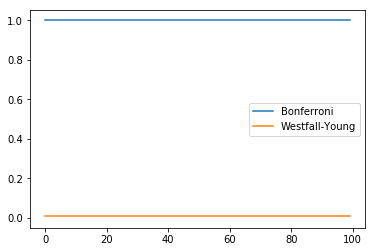

In [24]:
plt.plot(sorted(p1), label='Bonferroni')
plt.plot(sorted(p2), label='Westfall-Young')
plt.ylim([-0.05,1.05])
plt.legend(loc='best')
pass

## "Leave one out" resampling methods

### Jackknife estimate of parameters

This shows the leave-one-out calculation idiom for Python. Unlike R, a -k index to an array does not delete the kth entry, but returns the kth entry from the end, so we need another way to efficiently drop one scalar or vector. This can be done using Boolean indexing as shown in the examples below, and is efficient since the operations are on *views* of the original array rather than *copies*. Note also that 

In [25]:
def jackknife(x, func):
    """Jackknife estimate of the estimator func"""
    n = len(x)
    idx = np.arange(n)
    return np.sum(func(x[idx!=i]) for i in range(n))/float(n)

In [26]:
# Jackknife estimate of standard deviation
x = np.random.normal(0, 2, 100)
jackknife(x, np.std)

/Users/cliburn/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """


2.0289604502026446

In [27]:
def jackknife_var(x, func):
    """Jackknife estiamte of the variance of the estimator func."""
    n = len(x)
    idx = np.arange(n)
    j_est = jackknife(x, func)
    return (n-1)/(n + 0.0) * np.sum((func(x[idx!=i]) - j_est)**2.0 for i in range(n))

In [28]:
# estimate of the variance of an estimator 
jackknife_var(x, np.std)

/Users/cliburn/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
/Users/cliburn/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


0.022183139180399065

### Leave one out cross validation (LOOCV)

LOOCV also uses the same idiom, and a simple example of LOOCV for model selection is illustrated.

In [29]:
a, b, c = 2, 3, 4
x = np.linspace(0, 5, 6)
y = a*x**2 + b*x + c + np.random.normal(0, 3, len(x))

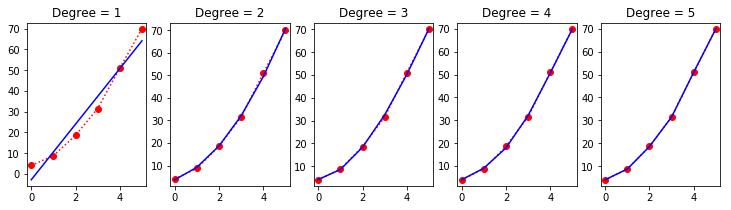

In [30]:
plt.figure(figsize=(15,3))
for deg in range(1, 6):
    plt.subplot(1, 6, deg)
    beta = np.polyfit(x, y, deg)
    plt.plot(x, y, 'r:o')
    plt.plot(x, np.polyval(beta, x), 'b-')
    plt.title('Degree = %d' % deg)
    plt.margins(0.04)

In [31]:
def loocv(x, y, fit, pred, deg):
    """LOOCV RSS for fitting a polynomial model."""
    n = len(x)
    idx = np.arange(n)
    rss = np.sum([(y - pred(fit(x[idx!=i], y[idx!=i], deg), x))**2.0 for i in range(n)])
    return rss

In [32]:
# RSS does not detect overfitting and selects the most complex model
for deg in range(1, 6):
    print('Degree = %d, RSS=%.2f' % (deg, np.sum((y - np.polyval(np.polyfit(x, y, deg), x))**2.0)))

Degree = 1, RSS=148.25
Degree = 2, RSS=3.83
Degree = 3, RSS=2.03
Degree = 4, RSS=1.07
Degree = 5, RSS=0.00


In [33]:
# LOOCV selects a more conservative model
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for deg in range(1, 6):
        print('Degree = %d, RSS=%.2f' % (deg, loocv(x, y, np.polyfit, np.polyval, deg)))

Degree = 1, RSS=1097.45
Degree = 2, RSS=43.30
Degree = 3, RSS=63.70
Degree = 4, RSS=563.94
Degree = 5, RSS=564.83


Simulations to estimate power
----

What sample size is needed for the t-test to have a power of 0.8 with an effect size of 0.5?

This is a toy example, since you can calculate it exactly,  but the simulation approach works for *everything*, including arbitrarily complex experimental designs, correcting for multiple comparisons and so on (assuming infinite computational resources).

In [34]:
# Run nresps simulations
# The power is simply the fraction of reps where 
# the p-value is less than 0.05

nreps = 10000
d = 0.5

n = 50
power = 0
while power < 0.8:
    n1 = n2 = n
    x = np.random.normal(0, 1, (n1, nreps))
    y = np.random.normal(d, 1, (n2, nreps))
    t, p = stats.ttest_ind(x, y)
    power = (p < 0.05).sum()/nreps
    print(n, power)
    n += 1

50 0.6997
51 0.7063
52 0.7123
53 0.7184
54 0.7346
55 0.7351
56 0.7406
57 0.7584
58 0.7612
59 0.7645
60 0.7749
61 0.7877
62 0.7862
63 0.7911
64 0.8007


## Estimating CDF and PDF from Monte Carlo samples

Given a bunch of random numbers from a simulation experiment, one of the first steps is to visualize the CDF and PDF. The ECDF is quite useful for, say, visualizing how similar or different two sets of data are.

### Estimating the CDF

In [35]:
# Make up some random data
x = np.r_[np.random.normal(0, 1, 10000), 
          np.random.normal(4, 1, 10000)]

In [36]:
# Roll our own ECDF function

def ecdf(x):
    """Return empirical CDF of x."""
    
    sx = np.sort(x)
    cdf = (1.0 + np.arange(len(sx)))/len(sx)
    return sx, cdf

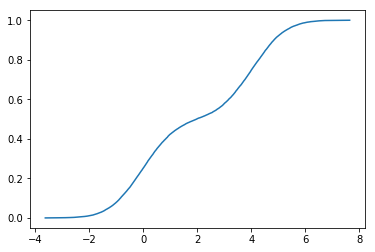

In [37]:
sx, y = ecdf(x)
plt.plot(sx, y)
pass

#### Using library routines

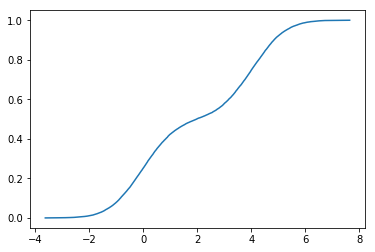

In [38]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(x)
plt.plot(ecdf.x, ecdf.y)
pass

### Estimating the PDF

The simplest is to plot a normalized histogram as shown above, but we will also look at how to estimate density functions using kernel density estimation (KDE). KDE works by placing a kernel unit on each data point, and summing the kernels to present a smoother estimate than you would get with a (n-d) histogram.

In [39]:
def epanechnikov(u):
    """Epanechnikov kernel."""
    return np.where(np.abs(u) <= np.sqrt(5), 3/(4*np.sqrt(5)) * (1 - u*u/5.0), 0)

def silverman(y):
    """Find bandwidth using heuristic suggested by Silverman
    .9 min(standard deviation, interquartile range/1.34)n−1/5
    """
    n = len(y)
    iqr = np.subtract(*np.percentile(y, [75, 25]))
    h = 0.9*np.min([y.std(ddof=1), iqr/1.34])*n**-0.2
    return h

def kde(x, y, bandwidth=silverman, kernel=epanechnikov):
    """Returns kernel density estimate.
    x are the points for evaluation
    y is the data to be fitted
    bandwidth is a function that returens the smoothing parameter h
    kernel is a function that gives weights to neighboring data
    """
    h = bandwidth(y)
    return np.sum(kernel((x-y[:, None])/h)/h, axis=0)/len(y)

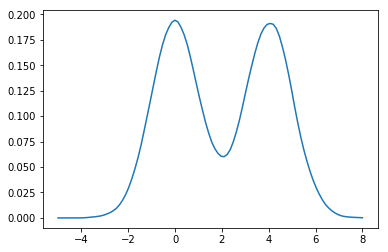

In [40]:
xs = np.linspace(-5,8,100)
density = kde(xs, x)
plt.plot(xs, density)
xlim = plt.xlim()
pass

#### Or just use `seaborn`

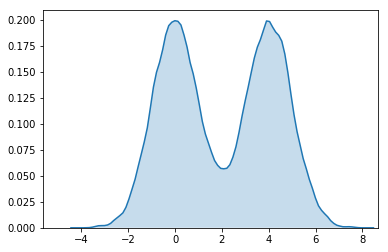

In [41]:
sns.kdeplot(x, kernel='epa', bw='silverman', shade=True)
plt.xlim(xlim)
pass

#### Other library routines

There are several kernel density estimation routines available in `scipy`, `statsmodels` and `scikit-leran`. Here we will use the `scikits-learn` and `statsmodels` routine as examples.

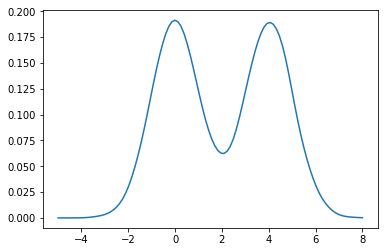

In [42]:
import statsmodels.api as sm

dens = sm.nonparametric.KDEUnivariate(x)
dens.fit(kernel='gau')
plt.plot(xs, dens.evaluate(xs))
pass

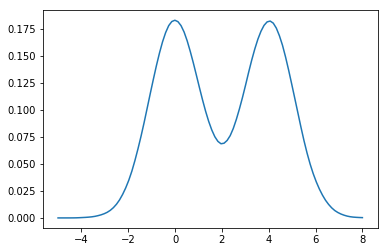

In [43]:
from sklearn.neighbors import KernelDensity 

# expects n x p matrix with p features
x.shape = (len(x), 1)
xs.shape = (len(xs), 1)

kde = KernelDensity(kernel='epanechnikov').fit(x)
dens = np.exp(kde.score_samples(xs))
plt.plot(xs, dens)
pass